## generate image with random PWM values

C:\Users\plasma\AppData\Local\Temp\ipykernel_20300\2668042787.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[pwms], [0], [0], [0], [0]]).astype(int)


The original PWM randomly set by [2994, 0, 0, 0, 0].


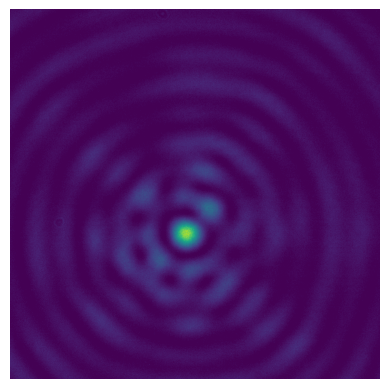

In [1]:
import csv
import numpy as np
import random
import time
from PIL import Image
from imageio import imwrite,imread
import os
from pylablib.devices import Thorlabs
from PIL import Image
import PIL.ImageOps 
import matplotlib.pyplot as plt 
  
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

import laserbeamsize as lbs
pwms = np.random.randint(low=0,high=4095,size=(1,1), dtype=np.int32)  
A = np.array([[pwms], [0], [0], [0], [0]]).astype(int)
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A)
raw_image_array = cam.grab(10) # grab 10 frames
image_array_initial=np.array(raw_image_array)
squeezed_image_array=image_array_initial.squeeze()
random_PWM=A
random_PWM_printed=A.ravel().tolist()
print(f"The original PWM randomly set by {random_PWM_printed}.")
plt.axis('off')
plt.imshow(image_array_initial[0])
cam.close()


In [2]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob
import math
from skimage.filters import sobel

def get_quality_number(squeezed_image_array):
    Score = np.array([])  # Create an empty NumPy array
    for i in range(len(squeezed_image_array)):
        [x_max, y_max] = np.unravel_index(np.argmax(squeezed_image_array[i]), squeezed_image_array[i].shape)
        [m, n] = np.where(squeezed_image_array[i] == round(np.max(squeezed_image_array[i]) / math.exp(1)))
        length = np.sqrt(np.power(abs(m - x_max), 2) + np.power(abs(n - y_max), 2))
        Score = np.append(Score, np.mean(length) / np.max(length))  # Append values to the NumPy array

    return np.mean(Score)  # Calculate the mean of the Score array

# Test your function

s1 = get_quality_number(squeezed_image_array)
print(s1)


0.5488620018760247


In [3]:
def set_PWMs(pwms):
    # Your code that sets the PWMs
    A = np.array([[pwms[0]], [pwms[1]], [pwms[2]], [pwms[3]], [pwms[4]]]).astype(int)
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    return 0

In [4]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
# cam.close()
cam.set_exposure(0.0001) # set exposure to 100ms
# frame = cam.snap() # grab a single frame
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

(0, 1000, 0, 1000, 1, 1)

In [5]:
def do_annealing(wait=5*33*0.03):
    # Annealing
    with open('PWM_test.csv', 'r', encoding='utf-8') as pwm_file:
        pwm_data = pwm_file.readlines()
    # Write data to do_annealing.csv
    with open('do_annealing.csv', 'w', encoding='utf-8') as annealing_file:
        annealing_file.writelines(pwm_data)
    time.sleep(wait) # Wait for annealing to complete

In [6]:
def get_quality_number1():

    #take image and calculate the quality number
    raw_image_array = cam.grab(10)    # grab 10 frame
    image_array=np.array(raw_image_array)
    squeezed_image_array=image_array.squeeze()
    score=[]
    for i in range (len(squeezed_image_array)):
        [x_max,y_max] = np.unravel_index(np.argmax(squeezed_image_array[i]), squeezed_image_array[i].shape) 
        [m,n]=np.where(squeezed_image_array[i]==round(np.max(squeezed_image_array[i])/math.exp(1)))
        length = np.sqrt(np.power(abs(m-x_max),2)+np.power(abs(n-y_max),2))
        score.append(np.mean(length)/np.max(length))
    average_score=np.mean(score)
    quality_number = average_score
    return quality_number

In [7]:
# SYNTHESIS and CHARACTERISATION
from OptimizationTestFunctions import Sphere, plot_3d
def set_PWMs_and_get_quality(pwms,sphere_test=False, annealing=False):
    if sphere_test:
        f = Sphere(dim=5,degree=2)
        #return -1*f(pwms)
        return -1*f(pwms)/1000000
    else:
        set_PWMs(pwms)
        quality_number = get_quality_number1()
        if annealing:
            do_annealing()
        return quality_number

In [8]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from botorch.acquisition import qLogExpectedImprovement

In [9]:
# Random Strategy

import random

def get_random_PWMs():
    random_value = random.randint(0, 4095)
    return [random_value] + [0] * 4
random_PWMs = get_random_PWMs()
print(random_PWMs)

[2797, 0, 0, 0, 0]


In [10]:
# Bayesian Opt Strategy

import numpy as np
import pandas as pd

from botorch.acquisition import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler

sampler = SobolQMCNormalSampler(sample_shape=torch.Size([512]), seed=0)
torch.manual_seed(seed=0)  # to keep the restart conditions the same    

def calculate_BO_candidate(samples):
    train_X = samples[["p1"]]
    train_Y = samples[["error"]]

    train_X = torch.tensor(train_X.to_numpy(dtype=np.float64))
    train_Y = torch.tensor(train_Y.to_numpy(dtype=np.float64))

    gp = SingleTaskGP(train_X, train_Y, input_transform=Normalize(d=train_X.shape[-1]), outcome_transform=Standardize(m=train_Y.shape[-1]),)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    #from botorch.acquisition import UpperConfidenceBound
    #UCB = UpperConfidenceBound(gp, beta=.1)

    MC_EI = qLogExpectedImprovement(gp, best_f=train_Y.max(), sampler=sampler)

    
    from botorch.optim import optimize_acqf
    bounds = torch.stack([torch.zeros(1), torch.ones(1)*4095])
    #bounds = torch.stack([torch.zeros(5), torch.ones(5)*5])

    candidate, acq_value = optimize_acqf(
        MC_EI, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    candidate = candidate[0]
    return candidate

Optimisation Loop:

In [11]:
import random
import pandas as pd
import time

N_TRIALS = 15
N_ITERATIONS = 100
USE_TEST_FUNCTION =False

best_random_all = []
best_BO_all = []
random_trial_samples = []
BO_trial_samples = []



for trial in range(N_TRIALS):
    print(f"Trial {trial}")
    BO_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial', "iteration", "timestamp"])
    random_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial', "iteration", "timestamp"])
    BO_current_candidate = get_random_PWMs()
    random_current_candidate = get_random_PWMs()
    
    best_random = []
    best_BO = []

    for iteration in range(N_ITERATIONS):
        
        #print(f"Iteration {iteration}")
        # Random Search
        random_current_quality = set_PWMs_and_get_quality(random_current_candidate, sphere_test=USE_TEST_FUNCTION)
        new_sample = {f"p{i+1}": p for i, p in enumerate(random_current_candidate)}
        new_sample["error"] = random_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] = trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        random_samples = pd.concat([random_samples, new_sample], axis=0, ignore_index=True)
        random_current_candidate = get_random_PWMs()
        
        # Bayesian Optimization
        BO_current_quality = set_PWMs_and_get_quality(BO_current_candidate, sphere_test=USE_TEST_FUNCTION)
        new_sample = {f"p{i+1}": p for i, p in enumerate(BO_current_candidate)}
        new_sample["error"] = BO_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] = trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        BO_samples = pd.concat([BO_samples, new_sample], axis=0, ignore_index=True)
        
        if iteration < 10:
            BO_current_candidate = get_random_PWMs()
        else:
            BO_current_candidate = calculate_BO_candidate(BO_samples)
            BO_current_candidate=[BO_current_candidate[0],0,0,0,0]
#             BO_current_candidate = [torch.round(x) for x in BO_current_candidate]
            BO_current_candidate = [torch.round(x) if isinstance(x, torch.Tensor) else x for x in BO_current_candidate]

        
        best_random.append(random_samples["error"].max())
        best_BO.append(BO_samples["error"].max())
        
    random_trial_samples.append(random_samples.copy(deep=True))
    BO_trial_samples.append(BO_samples.copy(deep=True))
    
    best_random_all.append(best_random)
    best_BO_all.append(best_BO)

    # Print the best BO parameters and value for the current trial
    best_BO_value = max(best_BO)
    best_BO_index = best_BO.index(best_BO_value)
    best_BO_params = BO_trial_samples[trial].loc[best_BO_index, ['p1', 'p2', 'p3', 'p4', 'p5']].tolist()
    print(f"Best BO Parameters (Trial {trial}):", best_BO_params)
    print(f"Best BO Value (Trial {trial}):", best_BO_value)
    print("=" * 30)
import pickle
# open a file, where you ant to store the data
filename = 'results_'+str(time.time())
file = open(filename, 'wb')

# dump information to that file
data = (random_trial_samples, BO_trial_samples, best_random_all, best_BO_all)
pickle.dump(data, file)
# close the file
file.close()



Trial 0
Best BO Parameters (Trial 0): [tensor(4049.), 0, 0, 0, 0]
Best BO Value (Trial 0): 0.857822936302119
Trial 1
Best BO Parameters (Trial 1): [tensor(4018.), 0, 0, 0, 0]
Best BO Value (Trial 1): 0.6619024992302177
Trial 2
Best BO Parameters (Trial 2): [tensor(8.), 0, 0, 0, 0]
Best BO Value (Trial 2): 0.8259301135564596
Trial 3
Best BO Parameters (Trial 3): [tensor(2995.), 0, 0, 0, 0]
Best BO Value (Trial 3): 0.8218727658758345
Trial 4
Best BO Parameters (Trial 4): [tensor(4095.), 0, 0, 0, 0]
Best BO Value (Trial 4): 0.8549914311197838
Trial 5
Best BO Parameters (Trial 5): [tensor(1976.), 0, 0, 0, 0]
Best BO Value (Trial 5): 0.7789441300591735
Trial 6
Best BO Parameters (Trial 6): [tensor(3052.), 0, 0, 0, 0]
Best BO Value (Trial 6): 0.8345098156970432
Trial 7
Best BO Parameters (Trial 7): [tensor(2927.), 0, 0, 0, 0]
Best BO Value (Trial 7): 0.8546431808214123
Trial 8
Best BO Parameters (Trial 8): [1450, 0, 0, 0, 0]
Best BO Value (Trial 8): 0.8505181806173049
Trial 9
Best BO Paramet

In [12]:
BO_trial_samples

[               p1 p2 p3 p4 p5     error trial iteration     timestamp
 0             659  0  0  0  0  0.321841     0         0  1.694735e+09
 1             363  0  0  0  0  0.645274     0         1  1.694735e+09
 2            3707  0  0  0  0  0.663938     0         2  1.694735e+09
 3            1206  0  0  0  0  0.835224     0         3  1.694735e+09
 4            2020  0  0  0  0  0.713837     0         4  1.694735e+09
 ..            ... .. .. .. ..       ...   ...       ...           ...
 95  tensor(3084.)  0  0  0  0  0.598979     0        95  1.694735e+09
 96  tensor(3020.)  0  0  0  0  0.502675     0        96  1.694735e+09
 97  tensor(3169.)  0  0  0  0  0.512842     0        97  1.694735e+09
 98  tensor(3041.)  0  0  0  0  0.627965     0        98  1.694735e+09
 99  tensor(2911.)  0  0  0  0  0.633780     0        99  1.694735e+09
 
 [100 rows x 9 columns],
                p1 p2 p3 p4 p5     error trial iteration     timestamp
 0            2309  0  0  0  0  0.404689     1    

In [13]:
best_BO_all

[[0.321840544261123,
  0.645273711176784,
  0.6639380566740871,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.8352242847242719,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302119,
  0.857822936302

## Plot results

In [14]:
filename

'results_1694738432.6841536'

In [15]:
# open a file, where you stored the pickled data
file = open(filename, 'rb')

# dump information to that file
data = pickle.load(file)
random_trial_samples, BO_trial_samples, best_random_all, best_BO_all = data

# close the file
file.close()

print('Showing the pickled data:')

cnt = 0
for item in data:
    print('The data ', cnt, ' is : ', item)
    cnt += 1


Showing the pickled data:
The data  0  is :  [      p1 p2 p3 p4 p5     error trial iteration     timestamp
0   3732  0  0  0  0  0.501347     0         0  1.694735e+09
1   2978  0  0  0  0  0.865443     0         1  1.694735e+09
2   3688  0  0  0  0  0.767750     0         2  1.694735e+09
3    163  0  0  0  0  0.458422     0         3  1.694735e+09
4    589  0  0  0  0  0.858355     0         4  1.694735e+09
..   ... .. .. .. ..       ...   ...       ...           ...
95  3979  0  0  0  0  0.473617     0        95  1.694735e+09
96  3586  0  0  0  0  0.491998     0        96  1.694735e+09
97  1636  0  0  0  0  0.349965     0        97  1.694735e+09
98  3519  0  0  0  0  0.612790     0        98  1.694735e+09
99    81  0  0  0  0  0.616189     0        99  1.694735e+09

[100 rows x 9 columns],       p1 p2 p3 p4 p5     error trial iteration     timestamp
0   2573  0  0  0  0  0.439896     1         0  1.694735e+09
1   2715  0  0  0  0  0.508052     1         1  1.694735e+09
2   1887  0  0

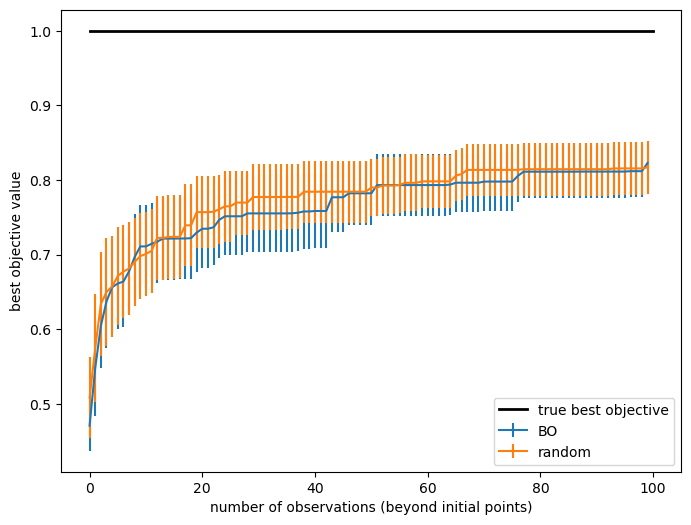

In [16]:
import numpy as np
from matplotlib import pyplot as plt


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

GLOBAL_MAXIMUM = 1
if USE_TEST_FUNCTION:
    GLOBAL_MAXIUM = 0



iters = np.arange(N_ITERATIONS)
y_random = np.asarray(best_random_all)
y_BO = np.asarray(best_BO_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.errorbar(iters, y_BO.mean(axis=0), yerr=ci(y_BO), label="BO", linewidth=1.5)
ax.errorbar(iters, y_random.mean(axis=0), yerr=ci(y_random), label="random", linewidth=1.5)
plt.plot(
    [0, N_ITERATIONS],
    [GLOBAL_MAXIMUM] * 2,
    "k",
    label="true best objective",
    linewidth=2,
)
#ax.set_ylim(bottom=0.5)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="best objective value",
)
ax.legend(loc="lower right")

In [17]:
y_BO

array([[0.32184054, 0.64527371, 0.66393806, ..., 0.85782294, 0.85782294,
        0.85782294],
       [0.40468919, 0.5448212 , 0.5448212 , ..., 0.6619025 , 0.6619025 ,
        0.6619025 ],
       [0.39618677, 0.41544582, 0.41544582, ..., 0.82593011, 0.82593011,
        0.82593011],
       ...,
       [0.50900263, 0.50900263, 0.58002136, ..., 0.86105585, 0.86105585,
        0.86105585],
       [0.40621516, 0.40621516, 0.56987811, ..., 0.83996592, 0.83996592,
        0.83996592],
       [0.51328841, 0.51328841, 0.6030773 , ..., 0.63009539, 0.63009539,
        0.79747593]])

In [18]:
y_random

array([[0.50134683, 0.86544307, 0.86544307, ..., 0.86544307, 0.86544307,
        0.86544307],
       [0.4398957 , 0.50805234, 0.58557815, ..., 0.63746126, 0.63746126,
        0.63746126],
       [0.42009461, 0.45477634, 0.56470838, ..., 0.8456427 , 0.8456427 ,
        0.8456427 ],
       ...,
       [0.49267222, 0.49267222, 0.84489846, ..., 0.85869152, 0.85869152,
        0.85869152],
       [0.43935049, 0.51577596, 0.51577596, ..., 0.84132187, 0.84132187,
        0.84132187],
       [0.42193035, 0.55504964, 0.63160191, ..., 0.86273751, 0.86273751,
        0.86273751]])

In [19]:
cam.close()

In [20]:
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

import laserbeamsize as lbs
A0 = np.array([[random_PWM[0]], [random_PWM[1]], [random_PWM[2]], [random_PWM[3]], [random_PWM[4]]])
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A0)
print(f"The original PWM randomly set by {random_PWM_printed} with score {s1}")

optimal_pwm_values=best_BO_params
A1= np.array([[optimal_pwm_values[0]], [optimal_pwm_values[1]], [optimal_pwm_values[2]], [optimal_pwm_values[3]], [optimal_pwm_values[4]]])
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A1)
raw_image_array1 = cam.grab(10) # grab 10 frames
image_array1=np.array(raw_image_array1)
squeezed_image_array1=image_array1.squeeze()
print(f"The suggested PWM values for correction is {optimal_pwm_values} with score {best_BO_value}")
cam.close()

The original PWM randomly set by [2994, 0, 0, 0, 0] with score 0.5488620018760247
The suggested PWM values for correction is [tensor(1546.), 0, 0, 0, 0] with score 0.7974759347761522


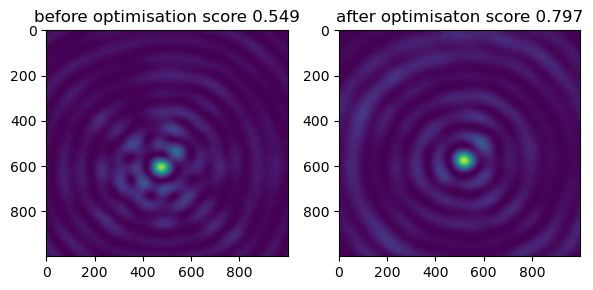

In [21]:
rows = 1
columns = 2
fig, (ax1, ax2) = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))
ax1.imshow(image_array_initial[0], aspect='auto')
ax1.set_title(f'before optimisation score {s1:.3f}')
ax2.imshow(image_array1[0], aspect='auto')
ax2.set_title(f'after optimisaton score {best_BO_value:.3f}')
fig.tight_layout() # used to adjust padding between subplots 

In [22]:
cam.close()

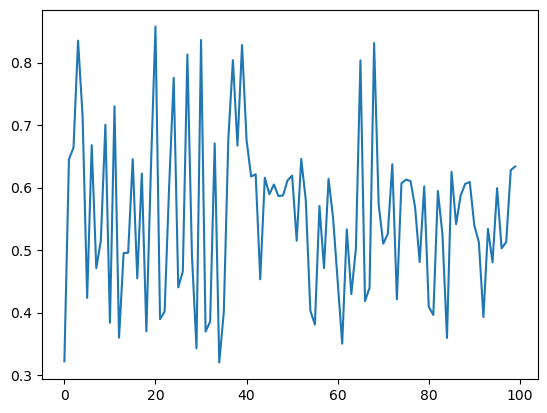

In [23]:
plt.plot(BO_trial_samples[0]["error"])